루브릭

|평가문항|상세기준|
|---|---|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.|

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


Step 1. 데이터 수집하기

In [2]:
!mkdir -p ~/aiffel/transformer_chatbot/data/
!ln -sf ~/data/* ~/aiffel/transformer_chatbot/data/
!ls ~/aiffel/transformer_chatbot/data/

'ChatbotData .csv'


In [3]:
import pandas as pd
data = pd.read_csv('/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv')

In [4]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


챗봇 트레이닝용 문답 페어 11,876개
일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

In [5]:
print('페어 샘플 갯수: {}'.format(len(data)) )

페어 샘플 갯수: 11823


In [6]:
data.label.value_counts()

0    5290
1    3570
2    2963
Name: label, dtype: int64

data 에 `label`이라는 열도 있었지만, 이 데이터는 사용하지 않기로 했다.

Step 2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [7]:
import re
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 숫자와 숫자가 아닌것들 사이에 거리를 만듭니다.
    sentence = re.sub(r"(\d+)", r" \1 ", sentence)
    # 연속한 빈칸은 1개의 빈칸으로 대체합니다.
    sentence = re.sub(r'[" "]]+', " ", sentence)

    # (a-z, A-Z, 한글:가-힣, 숫자:\d, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r'[^\da-zA-Z가-힣\.?!,]', " ", sentence)
    sentence = sentence.strip()
    return sentence

[루브릭] 공백과 특수문자 처리와 더불어서, 한국어에 대해서 preprocessing 할 수 있도록, `가-힣` 부분을 추가했다.

In [8]:
questions = data.Q.apply(preprocess_sentence).tolist()
answers = data.A.apply(preprocess_sentence).tolist()

### Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [9]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, 
    target_vocab_size=2**13)

[루브릭] preprocessing 된 corpus 로 부터 `tfds.deprecated.text.SubwordTextEncoder`를 사용하여 tokenize 했다. 

In [10]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 : [8160]
END_TOKEN의 번호 : [8161]
8162


In [11]:
# 길이 분포 확인
len_q = [len(s) for s in questions]
len_a = [len(s) for s in answers]

          questions       answers
count  11823.000000  11823.000000
mean      13.299586     16.077138
std        6.471054      6.853073
min        1.000000      1.000000
25%        9.000000     11.000000
50%       12.000000     15.000000
75%       17.000000     19.000000
max       57.000000     79.000000
33.0
39.0


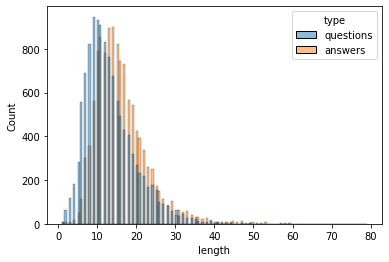

In [12]:
import seaborn as sns
tmp_df = pd.DataFrame(
    {'questions': len_q, 'answers':len_a})
sns.histplot(tmp_df.melt(
            value_vars=['questions', 'answers'], 
            var_name='type',
            value_name = 'length',),
             x='length', hue='type')
# sns.histplot(len_a, label='answers')

print(tmp_df.describe())
print(tmp_df['questions'].quantile(0.99))
print(tmp_df['answers'].quantile(0.99))

# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

[루브릭] 최대 길이를 정하기 위해서 question 과 answer 문장들의 토큰 개수의 분포를 분석했다. 99% 의 문장이 토큰 갯수가 39보다 작아서 `MAX_LENGTH = 40` 로 설정했다.

In [13]:
import tensorflow as tf
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [14]:
tokenized_Q, tokenized_A = tokenize_and_filter(questions, answers)

###### temp

In [15]:
answers[0]

'하루가 또 가네요 .'

In [16]:
tokenizer.decode([_id for _id in tokenized_A[0] if _id not in START_TOKEN + END_TOKEN])

'하루가 또 가네요 .'

In [17]:
tokenizer.decode([0,0,0,0])

''

###### Temp end

교사 강요(Teacher Forcing) 사용하기

In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': tokenized_Q,  # batch size, max_len
        'dec_inputs': tokenized_A[:, :-1] # batch size, max_len
    },
    {
        'outputs': tokenized_A[:, 1:] # batch size, max_len
    },
))

train_val_dataset = dataset.take(11823//5*4)
train_dataset = train_val_dataset.take(len(train_val_dataset)//5*4)
val_dataset = train_val_dataset.skip(len(train_val_dataset)//5*4)
test_dataset = dataset.skip(11823//5*4)

dataset = dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

In [19]:
import sys
sys.path.append('/aiffel/aiffel/transformer_chatbot')

In [20]:
from models import transformer

tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

슝=3
Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3143680     inputs[0][0]                     
                                                                 enc_padding_mask[0]

In [21]:
def loss_function(y_true, y_pred):
    # reshape y_true into (batch size, MAX_LENGTH-1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    # 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), # True if y_treu is 0, otherwise False
                   tf.float32) 
    # cast boolian tensor into tf.float32
    # to multiplicate with loss tensor(tf.float32)
    loss = tf.multiply(loss, mask) # element-wise multiplication

    return tf.reduce_mean(loss)

In [22]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step) # equal to step ** -0.5
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

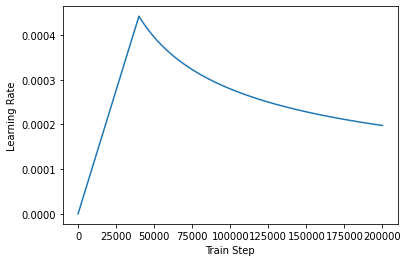

In [23]:
import matplotlib.pyplot as plt
sample_learning_rate = CustomSchedule(d_model=128, warmup_steps=4e+4)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [24]:
learning_rate = CustomSchedule(D_MODEL, warmup_steps=4e+4)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(
    optimizer=optimizer, 
    loss=loss_function, 
    metrics=[accuracy])

In [25]:
EPOCHS = 100
history = model.fit(train_dataset, 
                    epochs=EPOCHS, 
                    validation_data=val_dataset,
                    verbose=1)

Epoch 1/100
119/119 [==============================] - 15s 73ms/step - loss: 1.5027 - accuracy: 1.3560e-05 - val_loss: 1.6185 - val_accuracy: 4.0657e-05
Epoch 2/100
119/119 [==============================] - 7s 63ms/step - loss: 1.4749 - accuracy: 0.0069 - val_loss: 1.5726 - val_accuracy: 0.0252
Epoch 3/100
119/119 [==============================] - 7s 63ms/step - loss: 1.4265 - accuracy: 0.0261 - val_loss: 1.5185 - val_accuracy: 0.0294
Epoch 4/100
119/119 [==============================] - 7s 63ms/step - loss: 1.3814 - accuracy: 0.0332 - val_loss: 1.4781 - val_accuracy: 0.0451
Epoch 5/100
119/119 [==============================] - 8s 63ms/step - loss: 1.3471 - accuracy: 0.0395 - val_loss: 1.4486 - val_accuracy: 0.0479
Epoch 6/100
119/119 [==============================] - 7s 63ms/step - loss: 1.3191 - accuracy: 0.0436 - val_loss: 1.4239 - val_accuracy: 0.0498
Epoch 7/100
119/119 [==============================] - 7s 63ms/step - loss: 1.2925 - accuracy: 0.0472 - val_loss: 1.3977 - val_

119/119 [==============================] - 7s 63ms/step - loss: 0.5489 - accuracy: 0.0844 - val_loss: 1.0202 - val_accuracy: 0.0614
Epoch 58/100
119/119 [==============================] - 7s 63ms/step - loss: 0.5368 - accuracy: 0.0861 - val_loss: 1.0282 - val_accuracy: 0.0617
Epoch 59/100
119/119 [==============================] - 7s 62ms/step - loss: 0.5239 - accuracy: 0.0879 - val_loss: 1.0264 - val_accuracy: 0.0621
Epoch 60/100
119/119 [==============================] - 7s 63ms/step - loss: 0.5109 - accuracy: 0.0898 - val_loss: 1.0181 - val_accuracy: 0.0622
Epoch 61/100
119/119 [==============================] - 7s 63ms/step - loss: 0.4980 - accuracy: 0.0916 - val_loss: 1.0209 - val_accuracy: 0.0624
Epoch 62/100
119/119 [==============================] - 7s 62ms/step - loss: 0.4853 - accuracy: 0.0934 - val_loss: 1.0260 - val_accuracy: 0.0626
Epoch 63/100
119/119 [==============================] - 7s 62ms/step - loss: 0.4720 - accuracy: 0.0952 - val_loss: 1.0239 - val_accuracy: 0.062

In [26]:
model.save_weights(filepath='./models/transformer_e100_l7.4e-3_acc0.174.pt')

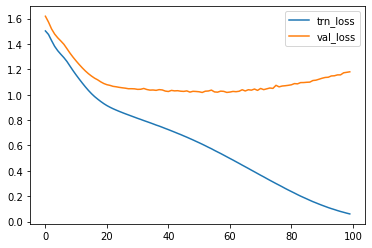

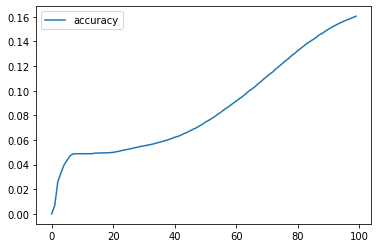

In [27]:
data = pd.DataFrame(history.history).reset_index()
plt.plot(data.index, data.loss, label='trn_loss')
plt.plot(data.index, data.val_loss, label='val_loss')
plt.legend();plt.show()
plt.plot(data.index, data.accuracy, label='accuracy')
plt.legend();plt.show()


[루브릭] validation loss의 양상을 통해서 Epoch 70 정도에서 멈춰야 함을 알 수 있었다.

Step 5. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [28]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
            START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :] # batch, position, embdding

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


In [48]:
def sentence_generation(sentence, tokenizer):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
            [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence


In [49]:
for i in range(15):
    sentence_generation(questions[i], tokenizer)
    print('정답 : {}'.format(answers[i]))
    print()

입력 : 12 시 땡 !
출력 : 어떤 꿈이었나요 .
정답 : 하루가 또 가네요 .

입력 : 1 지망 학교 떨어졌어
출력 : 좋은 사람 만날 거예요 .
정답 : 위로해 드립니다 .

입력 : 3 박 4 일 놀러가고 싶다
출력 : 인연이 거기까지인가봐요 .
정답 : 여행은 언제나 좋죠 .

입력 : 3 박 4 일 정도 놀러가고 싶다
출력 : 인연이 거기까지인가봐요 .
정답 : 여행은 언제나 좋죠 .

입력 : ppl 심하네
출력 : 눈살이 찌푸려지죠 .
정답 : 눈살이 찌푸려지죠 .

입력 : sd카드 망가졌어
출력 : 다시 새로 사는 게 마음 편해요 .
정답 : 다시 새로 사는 게 마음 편해요 .

입력 : sd카드 안돼
출력 : 다시 새로 사는 게 마음 편해요 .
정답 : 다시 새로 사는 게 마음 편해요 .

입력 : sns 맞팔 왜 안하지
출력 : 잘 모르고 있을 수도 있어요 .
정답 : 잘 모르고 있을 수도 있어요 .

입력 : sns 시간낭비인 거 아는데 매일 하는 중
출력 : 시간을 정하고 해보세요 .
정답 : 시간을 정하고 해보세요 .

입력 : sns 시간낭비인데 자꾸 보게됨
출력 : 시간을 정하고 해보세요 .
정답 : 시간을 정하고 해보세요 .

입력 : sns보면 나만 빼고 다 행복해보여
출력 : 자랑하는 자리니까요 .
정답 : 자랑하는 자리니까요 .

입력 : 가끔 궁금해
출력 : 그 사람도 그럴 거예요 .
정답 : 그 사람도 그럴 거예요 .

입력 : 가끔 뭐하는지 궁금해
출력 : 그 사람도 그럴 거예요 .
정답 : 그 사람도 그럴 거예요 .

입력 : 가끔은 혼자인게 좋다
출력 : 혼자를 즐기세요 .
정답 : 혼자를 즐기세요 .

입력 : 가난한 자의 설움
출력 : 돈은 다시 들어올 거예요 .
정답 : 돈은 다시 들어올 거예요 .



### 회고

#### 배운점
- tokenize 해 줄 때, 의미의 단위로 tokenize를 해주는게 중요하다는 것을 확인했다.
- training 시에 validation set 을 꼭 사용하자. 그래야, 몇 epoch 까지 진행해야 할지 판단할 수 있다.
#### 아쉬운점
- encoder 의 embedding layer, decoder 의 embedding layer 를 분석해보고 싶었으나 시간이 부족해 수행하지 못했다.
- accuracy 외의 다른 지표도 시도해봤으면 좋을것 같다.
#### 느낀점
- transformer는 학습이 느리다.
- 성능을 높이기 위해서 전처리가 중요하다.
- 단순히 layer 만 늘려도 성능이 올라가는 경우가 있다.
    
#### 어려웠던점
- validation 을 지정하지 않았을 때, 최대 성능이 나오려면 몇 epoch까지 진행해야 할 지 감이 잘 안잡혔다.

In [30]:
dir(model)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_cluster_coordinator',
 '_compile_wa

In [31]:
model.inputs

[<KerasTensor: shape=(None, None) dtype=float32 (created by layer 'inputs')>,
 <KerasTensor: shape=(None, None) dtype=float32 (created by layer 'dec_inputs')>]

In [32]:
model.layers

In [33]:
sentence = '안녕 하세요?'
sentence = preprocess_sentence(sentence)
sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
# padding 을 안해도 되나?
# sentence = tf.keras.preprocessing.sequence.pad_sequences(
#         sentence, maxlen=MAX_LENGTH, padding='post')

model.layers[3]([sentence, model.layers[2](sentence)])

<tf.Tensor: shape=(1, 6, 256), dtype=float32, numpy=
array([[[-0.36796513,  0.23676953, -0.5288512 , ...,  0.89136475,
         -1.0551708 , -2.5948951 ],
        [-0.13195316, -0.39852348, -0.01726225, ...,  0.41848376,
         -1.9447049 , -0.9214369 ],
        [-0.2910844 , -0.07971798,  0.2893729 , ...,  0.995684  ,
         -1.3368616 , -2.607405  ],
        [-0.9663535 , -2.004987  , -0.82454914, ...,  1.2948133 ,
         -1.3946931 , -0.56325567],
        [-0.7994893 , -1.5427418 , -1.6632216 , ...,  0.40023646,
         -2.1893554 , -1.3792908 ],
        [-0.5265931 ,  0.28142145, -0.7585053 , ...,  0.95259833,
         -1.1687548 , -2.698477  ]]], dtype=float32)>

In [34]:
sentence

<tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[8160,  911, 7936,   89,    2, 8161]], dtype=int32)>

In [35]:
sentence_emb = model.layers[3].layers[1](sentence)

In [36]:

tokenizer.encode(preprocess_sentence('안녕 하세요?'))

[911, 7936, 89, 2]

In [37]:
all_vocabs = tf.expand_dims(
        START_TOKEN + list(range(tokenizer.vocab_size)) + END_TOKEN, axis=0)

In [38]:
all_vocabs_emb = model.layers[3].layers[1](all_vocabs)

In [39]:
all_vocabs_emb.shape

TensorShape([1, 8162, 256])

<AxesSubplot:ylabel='Count'>

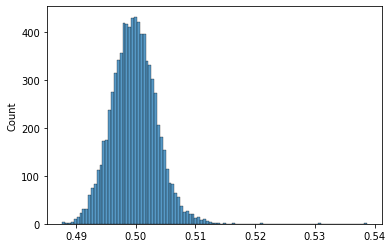

In [46]:
import numpy as np
# dot_prod = np.matmul(sentence_emb.numpy().squeeze(0), all_vocabs_emb.numpy().squeeze(0).T)
dot_prod = np.matmul(all_vocabs_emb.numpy().squeeze(0), all_vocabs_emb.numpy().squeeze(0).T) 

l2_norm_mat = np.matmul(
    np.expand_dims(np.linalg.norm(dot_prod, 2, 1), -1), 
    np.expand_dims(np.linalg.norm(dot_prod, 2, 1), -1).T )
dot_prod /= l2_norm_mat



# for i in range(dot_prod.shape[0]):
#     print(np.argmax(dot_prod[i]))
    
dot_prod #- tf.eye(dot_prod.shape[0])
# tf.nn.softmax(dot_prod - tf.eye(dot_prod.shape[0]), axis = 1) 
sns.histplot((dot_prod[0]+1)/2)
# sns.barplot(dot_prod[0])

In [ ]:
cos_sim_loss = tf.keras.losses.CosineSimilarity(axis = 1)
cos_sim_loss(sentence_emb[:,0:1,:], all_vocabs_emb)

In [ ]:
dir(tokenizer)

In [ ]:
dir(model.layers[3].layers)